# Project: Behavioral Cloning
- State: This version development was stopped
- Note: It was not possible to record quality simulation data to improve Ver

## Download data


In [1]:
# HMA: Automate data download for AWS spot usage 
# Check / Download / Unzip - Dataset

import os
simulationData_DIR = './00-proj-simulationDataUdacity'
simulationData_ZIP = './00-proj-simulationDataUdacity.zip'

if not(os.path.isdir(simulationData_DIR)):
    if not(os.path.exists(simulationData_ZIP)):
        # Download Dataset zipfile if DIR and ZIP file do not exist
        import urllib.request
        url = 'https://d17h27t6h515a5.cloudfront.net/topher/2016/December/584f6edd_data/data.zip'
        print("Downloading Simulation Data...")
        urllib.request.urlretrieve(url, simulationData_ZIP)
    
    # Unzip Dataset zipfile
    if (os.path.exists(simulationData_ZIP)):
        print("Unzipping Simulation Data...")
        os.makedirs(simulationData_DIR)
        import zipfile
        zip_ref = zipfile.ZipFile(simulationData_ZIP, 'r')
        zip_ref.extractall(simulationData_DIR)
        zip_ref.close()
print("Dataset ready.")

Dataset ready.


## Import data

In [2]:
# Read log file
# [0] center image
# [1] left image
# [2] right image
# [3] steering angle

import csv

log_DIR = os.path.join(simulationData_DIR, 'data')
log_FILE = 'driving_log.csv'
driving_log = []
with open(os.path.join(log_DIR, log_FILE)) as csvfile:
    reader = csv.reader(csvfile, escapechar=' ')
    for line in reader:
        driving_log.append(line)

driving_log = driving_log[1:] # crop CSV titles
pass

Perform steps to augment the training data:
- Use captured images from the left camera with steering angle minus delta as example image to return to the center
- Use captured images from the right camera with steering angle plux delta as example image to return to the center

In [3]:
import cv2

img_DIR = log_DIR
centerCamImageIndex = 0
leftCamImageIndex   = 1
rightCamImageIndex  = 2
steeringAngleIndex  = 3

logSet = []
deltaAngle = 0.25
for log_entry in driving_log:
    img_FILE = log_entry[centerCamImageIndex]
    angle = float(log_entry[steeringAngleIndex])
    logSet.append([img_FILE, angle, False])
    logSet.append([img_FILE, -angle, True])
    
    img_FILE = log_entry[leftCamImageIndex]
    angle = float(log_entry[steeringAngleIndex]) + deltaAngle
    logSet.append([img_FILE, angle, False])
    logSet.append([img_FILE, -angle, True])
    
    img_FILE = log_entry[rightCamImageIndex]
    angle = float(log_entry[steeringAngleIndex]) - deltaAngle
    logSet.append([img_FILE, angle, False])
    logSet.append([img_FILE, -angle, True])

In [4]:
import cv2
import numpy as np

imgIndex = 0
angleIndex = 1
flipIndex = 2

def generator(samples, batch_size=32):
    while True:
        for offset in range(0, len(samples), batch_size):
            batch_samples = samples[offset:offset + batch_size]
            imgSet = []
            angleSet = []
            
            for log_entry in batch_samples:
                img_FILE = log_entry[imgIndex]
                img = cv2.imread(os.path.join(img_DIR, img_FILE))
                if log_entry[flipIndex] == True:
                    img = cv2.flip(img, 1)
                imgSet.append(img)
                angleSet.append(log_entry[angleIndex])

            X_train = np.array(imgSet)
            y_train = np.array(angleSet)
            yield sklearn.utils.shuffle(X_train, y_train)


In [5]:
import sklearn
from sklearn.model_selection import train_test_split

sklearn.utils.shuffle(logSet)
logSet_train, logSet_valid = sklearn.model_selection.train_test_split(logSet, test_size=0.2)

train_generator = generator(logSet_train, batch_size=32)
validation_generator = generator(logSet_valid, batch_size=32)

## Define Model

In [6]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Convolution2D

model = Sequential()
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((70,25), (0,0))))
model.add(Convolution2D(24, 5, 5, subsample=(2,2), activation='relu'))
model.add(Convolution2D(36, 5, 5, subsample=(2,2), activation='relu'))
model.add(Convolution2D(48, 5, 5, subsample=(2,2), activation='relu'))
model.add(Convolution2D(64, 3, 3, activation='relu'))
model.add(Convolution2D(64, 3, 3, activation='relu'))
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

Using TensorFlow backend.


In [6]:
model.compile(loss='mse', optimizer='adam')
history_object = model.fit_generator(train_generator, 
                                     samples_per_epoch=len(logSet_train), 
                                     validation_data=validation_generator,
                                     nb_val_samples=len(logSet_valid), 
                                     nb_epoch=5, 
                                     verbose=2)
model.save('model.h5')

Using TensorFlow backend.


Epoch 1/5
94s - loss: 0.0234 - val_loss: 0.0222
Epoch 2/5
90s - loss: 0.0199 - val_loss: 0.0197
Epoch 3/5
87s - loss: 0.0182 - val_loss: 0.0189
Epoch 4/5
88s - loss: 0.0167 - val_loss: 0.0175
Epoch 5/5
86s - loss: 0.0153 - val_loss: 0.0178


In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

def plotHistory():
    global history_object 
    ### print the keys contained in the history object
    print(history_object.history.keys())

    ### plot the training and validation loss for each epoch
    plt.plot(history_object.history['loss'])
    plt.plot(history_object.history['val_loss'])
    plt.title('model mean squared error loss')
    plt.ylabel('mean squared error loss')
    plt.xlabel('epoch')
    plt.legend(['training set', 'validation set'], loc='upper right')
    plt.show()

dict_keys(['loss', 'val_loss'])


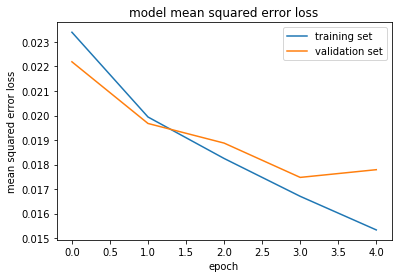

In [7]:
plotHistory()

In [ ]:
import os
simulationRefineData_DIR = './00-proj-simulationDataRefine01'
simulationRefineData_ZIP = '00-proj-simulationDataRefine01.zip'

os.makedirs(simulationRefineData_DIR)
import zipfile
zip_ref = zipfile.ZipFile(simulationRefineData_ZIP, 'r')
zip_ref.extractall(simulationRefineData_DIR)
zip_ref.close()

In [8]:
# Read log file
# [0] center image
# [1] left image
# [2] right image
# [3] steering angle

import csv

log_DIR = simulationRefineData_DIR
log_FILE = 'driving_log.csv'
driving_log = []
with open(os.path.join(log_DIR, log_FILE)) as csvfile:
    reader = csv.reader(csvfile, escapechar=' ')
    for line in reader:
        driving_log.append(line)

driving_log = driving_log[1:] # crop CSV titles
pass

In [9]:
len(logSet)

48216

In [11]:
logSet_save = list(logSet)

In [12]:
import cv2

deltaAngle = 0.25
for log_entry in driving_log:
    img_FILE = log_entry[centerCamImageIndex]
    angle = float(log_entry[steeringAngleIndex])
    logSet.append([img_FILE, angle, False])
    logSet.append([img_FILE, -angle, True])

In [13]:
len(logSet)

64288

In [14]:
sklearn.utils.shuffle(logSet)
logSet_train, logSet_valid = sklearn.model_selection.train_test_split(logSet, test_size=0.2)

train_generator = generator(logSet_train, batch_size=32)
validation_generator = generator(logSet_valid, batch_size=32)

In [15]:
from keras.models import load_model
model = load_model('model.h5')

Using TensorFlow backend.


In [16]:
history_object = model.fit_generator(train_generator, 
                                     samples_per_epoch=len(logSet_train), 
                                     validation_data=validation_generator,
                                     nb_val_samples=len(logSet_valid), 
                                     nb_epoch=3, 
                                     verbose=2)
model.save('model.h5')

Epoch 1/3
107s - loss: 0.0141 - val_loss: 0.0145
Epoch 2/3
107s - loss: 0.0124 - val_loss: 0.0136
Epoch 3/3
106s - loss: 0.0109 - val_loss: 0.0135


In [ ]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)


## Train Model